In [1]:
import pandas as pd

eb = pd.read_csv("../emobank.csv", index_col=0)

print(eb.shape)
eb.head()



(10062, 5)


,split,V,A,D,text
id,,,,,
110CYL068_1036_1079,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
110CYL068_1079_1110,test,2.80,3.10,2.80,If I wasn't working here.
110CYL068_1127_1130,train,3.00,3.00,3.00,".."""
110CYL068_1137_1188,train,3.44,3.00,3.22,Goodwill helps people get off of public assist...
110CYL068_1189_1328,train,3.55,3.27,3.46,Sherry learned through our Future Works class ...



## Regression models:

In [2]:
# ! pip install -U sentence-transformers

import sklearn
import numpy as np
import sklearn.model_selection
from transformers import BertTokenizer, BertModel
import torch
from sentence_transformers import SentenceTransformer
# Filter the DataFrame first
filtered_eb = eb[eb['text'].notna()]
# Then create arrays
xs = filtered_eb['text'].astype(str).tolist()
ys = np.column_stack((filtered_eb['V'], filtered_eb['A']))
# print(xs.shape,ys.shape)

# convert it to embeddings for NN.

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertModel.from_pretrained("bert-base-uncased")
#
# tokens = tokenizer(xs, return_tensors="pt", padding=True, truncation=True)
# with torch.no_grad():
#     output = model(**tokens)
#
# embeddings = output.last_hidden_state[:, 0, :]  # Shape: (1, 768)
# xs = embeddings.numpy()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(xs)
print(embeddings.shape)
xs = embeddings

print(xs.shape)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(xs, ys, test_size=0.2)
# print(y_train.shape, y_test.shape)




(10061, 384)
(10061, 384)


## Random Forest


In [3]:
# null

## Neural Network

Input dimension: 384
Epoch 0: Train Loss = 1.001120, Val Loss = 0.988046
Epoch 10: Train Loss = 0.810026, Val Loss = 0.828494
Epoch 20: Train Loss = 0.672506, Val Loss = 0.722048
Epoch 30: Train Loss = 0.586344, Val Loss = 0.672294
Epoch 40: Train Loss = 0.527724, Val Loss = 0.654465
Epoch 50: Train Loss = 0.477921, Val Loss = 0.651995
Epoch 60: Train Loss = 0.428670, Val Loss = 0.658212
Early stopping triggered.
Final Losses:
Train MSE: 0.035490755
Val MSE: 0.059359774
Test MSE: 0.05773898


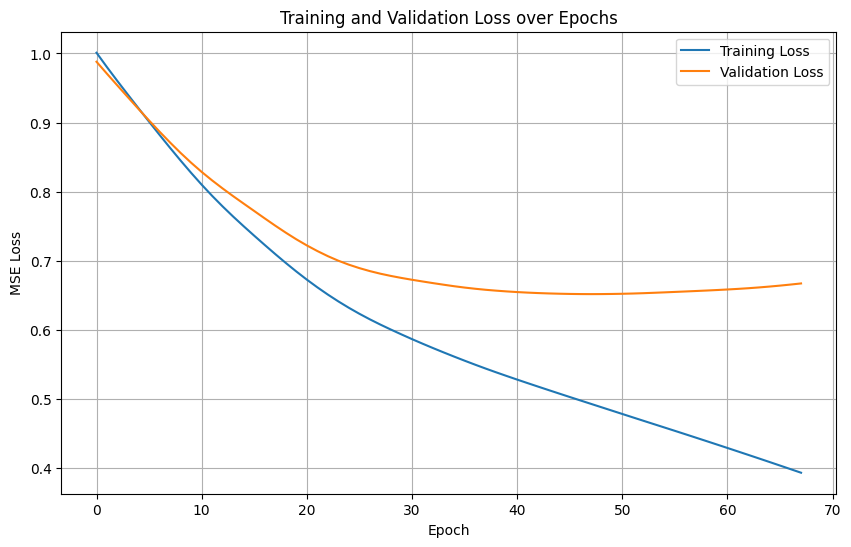

Created 'models' directory.
Scalers saved to models/feature_scaler.pkl and models/y_scaler.pkl.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import os  # Import the 'os' module

# Define the neural network model.
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        return self.network(x)

# Denormalisation helper.
def denormalise(y_norm, scaler):
    if isinstance(y_norm, torch.Tensor):
        y_norm = y_norm.detach().cpu().numpy()
    return scaler.inverse_transform(y_norm)

def find_nn(X_train, X_test, y_train, y_test):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create and fit scalers.
    feature_scaler = StandardScaler()
    X_train_norm = feature_scaler.fit_transform(X_train)
    X_test_norm = feature_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train_norm = y_scaler.fit_transform(y_train)
    y_test_norm = y_scaler.transform(y_test)

    # Split training data into training and validation sets.
    X_train_final, val_x, y_train_final, val_y = train_test_split(
        X_train_norm, y_train_norm, test_size=0.2, random_state=42
    )

    # Convert arrays to torch tensors.
    X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32).to(device)
    val_x_tensor = torch.tensor(val_x, dtype=torch.float32).to(device)
    val_y_tensor = torch.tensor(val_y, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32).to(device)

    input_dim = X_train_tensor.shape[1]
    model = NeuralNetworkModel(input_size=input_dim, hidden_size=64, output_size=2).to(device)
    print("Input dimension:", input_dim)
    loss_fn = nn.MSELoss()
    optimiser = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.5, patience=100, verbose=True)

    epochs = 3000
    patience = 20  # Increased patience
    stationary = 0
    min_val_loss = float('inf')
    train_losses = []
    val_losses = []

    torch.manual_seed(1)
    best_model_state = None

    # Training loop.
    for epoch in range(epochs):
        model.train()
        optimiser.zero_grad()
        train_pred = model(X_train_tensor)
        train_loss = loss_fn(train_pred, y_train_tensor)
        train_loss.backward()
        optimiser.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(val_x_tensor)
            val_loss = loss_fn(val_pred, val_y_tensor)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        scheduler.step(val_loss)

        if val_loss.item() < min_val_loss:
            min_val_loss = val_loss.item()
            stationary = 0
            best_model_state = model.state_dict()  # save best model state
        else:
            stationary += 1

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss.item():.6f}, Val Loss = {val_loss.item():.6f}")

        if stationary >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Evaluate on train, validation, and test sets.
    model.eval()
    with torch.no_grad():
        train_pred_norm = model(X_train_tensor)
        val_pred_norm = model(val_x_tensor)
        test_pred_norm = model(X_test_tensor)

    train_pred = denormalise(train_pred_norm, y_scaler)
    val_pred = denormalise(val_pred_norm, y_scaler)
    test_pred = denormalise(test_pred_norm, y_scaler)

    y_train_orig = y_scaler.inverse_transform(y_train_tensor.detach().cpu().numpy())
    val_y_orig = y_scaler.inverse_transform(val_y_tensor.detach().cpu().numpy())
    y_test_orig = y_scaler.inverse_transform(y_test_tensor.detach().cpu().numpy())

    train_mse = np.mean((train_pred - y_train_orig) ** 2)
    val_mse = np.mean((val_pred - val_y_orig) ** 2)
    test_mse = np.mean((test_pred - y_test_orig) ** 2)

    print("Final Losses:")
    print("Train MSE:", train_mse)
    print("Val MSE:", val_mse)
    print("Test MSE:", test_mse)

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create the 'models' directory if it doesn't exist
    if not os.path.exists("models"):
        os.makedirs("models")
        print("Created 'models' directory.")

    # Save the fitted scalers so they can be reused during inference.
    try:
        with open("models/feature_scaler.pkl", "wb") as f:
            pickle.dump(feature_scaler, f)
        with open("models/y_scaler.pkl", "wb") as f:
            pickle.dump(y_scaler, f)
        print("Scalers saved to models/feature_scaler.pkl and models/y_scaler.pkl.")
    except Exception as e:
        print(f"Error saving scalers: {e}")
        raise  # Re-raise the exception to halt execution

    return model

# Assuming X_train, X_test, y_train, y_test are defined earlier in your code.
regression_model = find_nn(X_train, X_test, y_train, y_test)


## Encoding the Embeddings


In [5]:

def embed_sentence(sentence):
    embedding = embedding_model.encode(sentence)
    print(sentence, embedding)
    return embedding

embed_sentence("I love you")


I love you [-1.09195411e-01  8.02101046e-02  6.88061416e-02 -6.74073920e-02
  3.87932383e-03 -3.21285613e-02  4.00463976e-02  1.16086937e-01
  7.09141940e-02 -4.51841131e-02 -5.86131252e-02 -1.25714662e-02
  5.34354821e-02  5.15695512e-02 -2.48878989e-02 -9.11433250e-03
 -3.77822407e-02 -1.70042105e-02 -1.20862961e-01  5.26175126e-02
 -7.48451352e-02 -2.34869048e-02 -2.70614158e-02  1.21036349e-02
 -5.27612716e-02  3.42209712e-02  1.73698664e-02 -1.72096211e-02
 -5.02260998e-02 -4.95034531e-02 -4.99411523e-02  1.44435046e-02
  7.47839883e-02  1.42010981e-02 -6.82560354e-02 -2.46662460e-02
 -5.88000119e-02 -8.68566893e-03  2.12926399e-02  2.03455836e-02
  2.34229509e-02 -4.40225005e-02  2.26232149e-02  9.40483622e-03
 -1.20196924e-01  2.02249680e-02 -2.10848022e-02  6.09594360e-02
  3.69253717e-02  9.65186432e-02 -1.98108219e-02 -1.33462613e-02
 -1.25698432e-01 -1.20242247e-02  6.64903075e-02  5.28456643e-02
  1.36994822e-02 -3.86061110e-02  7.82931969e-03  3.37165035e-02
  5.08572608e-

array([-1.09195411e-01,  8.02101046e-02,  6.88061416e-02, -6.74073920e-02,
        3.87932383e-03, -3.21285613e-02,  4.00463976e-02,  1.16086937e-01,
        7.09141940e-02, -4.51841131e-02, -5.86131252e-02, -1.25714662e-02,
        5.34354821e-02,  5.15695512e-02, -2.48878989e-02, -9.11433250e-03,
       -3.77822407e-02, -1.70042105e-02, -1.20862961e-01,  5.26175126e-02,
       -7.48451352e-02, -2.34869048e-02, -2.70614158e-02,  1.21036349e-02,
       -5.27612716e-02,  3.42209712e-02,  1.73698664e-02, -1.72096211e-02,
       -5.02260998e-02, -4.95034531e-02, -4.99411523e-02,  1.44435046e-02,
        7.47839883e-02,  1.42010981e-02, -6.82560354e-02, -2.46662460e-02,
       -5.88000119e-02, -8.68566893e-03,  2.12926399e-02,  2.03455836e-02,
        2.34229509e-02, -4.40225005e-02,  2.26232149e-02,  9.40483622e-03,
       -1.20196924e-01,  2.02249680e-02, -2.10848022e-02,  6.09594360e-02,
        3.69253717e-02,  9.65186432e-02, -1.98108219e-02, -1.33462613e-02,
       -1.25698432e-01, -

## Save Model

In [11]:
torch.save(regression_model, "models/regression_model.pth")


## Inference code





In [12]:
import torch
from sentence_transformers import SentenceTransformer
import pickle

# Assume regression_model is defined and loaded elsewhere.
# For example:
# regression_model = load_regression_model()  # Your function to load the model

model = SentenceTransformer("all-MiniLM-L6-v2")

# Function to embed a sentence.
def embed_sentence(sentence: str):
    return model.encode([sentence])

# Load the pre-fitted scalers (saved during training).
def load_scalers():
    with open("models/feature_scaler.pkl", "rb") as f:
        feature_scaler = pickle.load(f)
    with open("models/y_scaler.pkl", "rb") as f:
        y_scaler = pickle.load(f)
    return feature_scaler, y_scaler

def inference(sentence: str):
    embedding = embed_sentence(sentence)

    # Load both scalers
    feature_scaler, y_scaler = load_scalers()

    # Normalize the input embedding using the feature scaler
    embedding_norm = feature_scaler.transform(embedding)
    embedding_tensor = torch.tensor(embedding_norm, dtype=torch.float32)

    regression_model.eval()  # ensure model is in eval mode
    with torch.no_grad():
        y_pred_norm = regression_model(embedding_tensor)
        # Inverse transform using the pre-fitted scaler:
        y_pred = y_scaler.inverse_transform(y_pred_norm.numpy())
        print("valence, arousal:")
        print(sentence, "Prediction:", y_pred)
        return y_pred

# Example usage:
if __name__ == "__main__":
    # Make sure regression_model is loaded (e.g., via your load_regression_model() function)
    # and that "models/y_scaler.pkl" and "models/feature_scaler.pkl" exist.
    sentences = [
        "I just won the lottery! I can't stop jumping with excitement!",
        "I feel really happy just sitting here and enjoying the sunset.",
        "I'm peacefully relaxed after a long day at the spa.",
        "I'm furious! How could they betray me like that?",
        "I feel a little down, but it's just one of those days.",
        "I don't want to do anything.",
        "I hate everyone and everything.",
        "My mum is dead, but I don't care as I got her money."
    ]

    for sentence in sentences:
        inference(sentence)

valence, arousal:
I just won the lottery! I can't stop jumping with excitement! Prediction: [[4.1362934 4.3258543]]
valence, arousal:
I feel really happy just sitting here and enjoying the sunset. Prediction: [[3.9152899 3.383967 ]]
valence, arousal:
I'm peacefully relaxed after a long day at the spa. Prediction: [[3.4754431 3.0641894]]
valence, arousal:
I'm furious! How could they betray me like that? Prediction: [[2.0044487 3.9734573]]
valence, arousal:
I feel a little down, but it's just one of those days. Prediction: [[2.6722724 3.0365088]]
valence, arousal:
I don't want to do anything. Prediction: [[2.630218  3.1063545]]
valence, arousal:
I hate everyone and everything. Prediction: [[2.4289353 3.3120422]]
valence, arousal:
My mum is dead, but I don't care as I got her money. Prediction: [[2.5066848 3.0765953]]


## Save Model



In [13]:
state_dict = regression_model.state_dict()
for layer_name, weights in state_dict.items():
    print(layer_name, weights)

torch.save(regression_model.state_dict(), 'models/regression_dnn.pth')



network.0.weight tensor([[-0.0041,  0.0410,  0.0005,  ...,  0.0359,  0.0587,  0.0366],
        [ 0.0531,  0.0433, -0.0135,  ...,  0.0119, -0.0677, -0.0279],
        [-0.0027, -0.0469,  0.0423,  ..., -0.0615, -0.0058, -0.0226],
        ...,
        [-0.0538, -0.0154,  0.0002,  ...,  0.0210, -0.0479,  0.0388],
        [ 0.0833,  0.0119, -0.0654,  ..., -0.0156, -0.0072, -0.0414],
        [-0.0088,  0.0303, -0.0110,  ...,  0.0542, -0.0239,  0.0161]])
network.0.bias tensor([-0.0056, -0.0705,  0.0127,  0.0422,  0.0463,  0.0581,  0.0309, -0.0307,
        -0.0308,  0.0376,  0.0026,  0.0567, -0.0111,  0.0217,  0.0046,  0.0684,
        -0.0037,  0.0727, -0.0049,  0.0366,  0.0373,  0.0530, -0.0214, -0.0501,
        -0.0018, -0.0216,  0.0312,  0.0056, -0.0356, -0.0253, -0.0081,  0.0270,
        -0.0139, -0.0473,  0.0738, -0.0233, -0.0065,  0.0243, -0.0353,  0.0046,
        -0.0085, -0.0522,  0.0679,  0.0614,  0.0361,  0.0697, -0.0118, -0.0448,
        -0.0220, -0.0471, -0.0634, -0.0104, -0.0400,  